## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.
### Задача 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared.

In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import levene
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

Данные о времени регистрации:

In [2]:
reg = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Y5VgKt42xzbBlg', sep = ';')

Данные о времени захода пользователей в игру:

In [3]:
auth = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/r5Q2NH2t4bUy6g', sep = ';')

In [6]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [7]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
df=reg.merge(auth, how='right', on='uid')

In [10]:
df.head()

,reg_ts,uid,auth_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932683089,2,932921206
3,932683089,2,933393015
4,932683089,2,933875379


In [14]:
df['ret_day']=(df.auth_ts - df.reg_ts) // 86400

In [15]:
df.head()

,reg_ts,uid,auth_ts,ret_day
0,911382223,1,911382223,0
1,932683089,2,932683089,0
2,932683089,2,932921206,2
3,932683089,2,933393015,8
4,932683089,2,933875379,13


Соберем функцию:

In [2]:
def reten(ret_d):
    reg = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Y5VgKt42xzbBlg', sep = ';')
    auth = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/r5Q2NH2t4bUy6g', sep = ';')
    df=reg.merge(auth, how='right', on='uid')
    df['ret_day']=(df.auth_ts - df.reg_ts) // 86400
    count_reg=df.reg_ts.nunique()
    count_auth=df.query('ret_day == @ret_d').auth_ts.nunique()
    ret=count_auth / count_reg
    return ret

Проверим

In [3]:
reten(7)

0.043615

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
rev = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/tIC0ye1712SDIw', sep = ';')

In [4]:
rev.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Судя по условию задачи конверсия в покупку в контрольной группе выше, чем в тестовой. Проверим, есть ли в данных повторные покупки.

In [5]:
rev.shape

(404770, 3)

In [6]:
rev.user_id.nunique()

404770

Повторных покупок нет, продолжим анализировать ARPU и конверсию. Т.к. в расчете ARPPU участвует и ARPU и конверсия, то сосредоточимся только на ARPPU. Для этого необходимо определить, статистически ли значима разница между получившимися метриками в группах. 

Получим датафреймы с оплатами для каждой из групп

In [7]:
rev_a=rev.query('revenue > 0 and testgroup == "a"')

In [8]:
rev_b=rev.query('revenue > 0 and testgroup == "b"')

In [9]:
rev_a.shape

(1928, 3)

In [10]:
rev_b.shape

(1805, 3)

Посмотрим, насколько ARPPU в тестовой группе больше

In [11]:
arppu_a=rev_a.revenue.sum() / rev_a.user_id.count()
arppu_a

2663.9984439834025

In [12]:
arppu_b=rev_b.revenue.sum() / rev_b.user_id.count()
arppu_b

3003.6581717451522

In [13]:
arppu_b / arppu_a

1.1274999722799635

Итак, ARPPU в тестовой группе выше на 12,75%

Чтобы убедиться, что мы можем применить t-критерий, проверим гомогенность дисперсий и нормальность распределений.
Гомогенность двух дисперсий проверим по критерию Левена

In [18]:
stat, p = levene(rev_a.revenue, rev_b.revenue, center = 'mean')

In [19]:
p

1.3202514573715939e-93

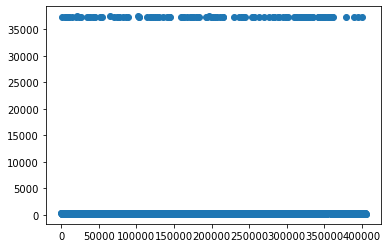

In [24]:
plt.scatter(rev_a.user_id, rev_a.revenue)
plt.show()

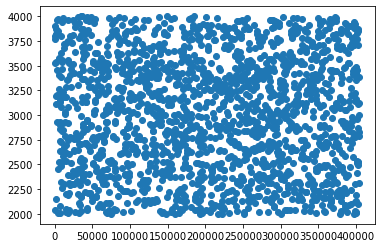

In [23]:
plt.scatter(rev_b.user_id, rev_b.revenue)
plt.show()

Проверим нормальность выборок

In [25]:
stats.shapiro(rev_a.revenue)

ShapiroResult(statistic=0.26679253578186035, pvalue=0.0)

In [26]:
stats.shapiro(rev_b.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

In [30]:
U1, p=stats.mannwhitneyu(rev_a.revenue, rev_b.revenue)

In [31]:
p

0.0

#### Вывод:
Разница между выборками значима и так как ARPPU в тестовой группе увеличилось, то измения стоит распространить на всех пользователей.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Решение:
Хорошо бы посмотреть DAU и сравнить его с DAU вне тематичнских событий. Также необходимо посмотреть изменение среднего времени пребывания в игре.

В усложненном варианте также проверить выше обозначенные метрики, но добавить ещё и charn - как маркер удовлетворённости игрой.